In [180]:
%matplotlib inline

from pymongo import MongoClient
import math
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

In [181]:
def divtd(td1, td2):
    us1 = td1.microseconds + 1000000 * (td1.seconds + 86400 * td1.days)
    us2 = td2.microseconds + 1000000 * (td2.seconds + 86400 * td2.days)
    return float(us1) / us2

try:
    import config
    print('using local config file')
    mongodb_uri = config.mongodb_uri
except:
    print('using environment variable')
    mongodb_uri = os.getenv('MONGODB_URI')

using local config file


In [182]:
print("Analyzing Test Data")
success = True

if success:
    try:
        client = MongoClient(mongodb_uri)
        db = client.get_database()
    except Exception as e:
        print('mongo login error ', str(e))
        success = False
if success:
    try:
        dataCursor = db.percentageMove.find(projection={'_id': False},sort=[("timestamp", 1)])
    except Exception as e:
        print('mongo data cursor error ', str(e))
        success = False
        
if success:
    try:
        df =  pd.DataFrame(list(dataCursor)).set_index(['timestamp'])
        print(df)
        increase = df+1
        cumulative = increase.cumprod(axis=0)
        cumulative = cumulative - cumulative.iloc[0]
        print(cumulative)
    except Exception as e:
        print('mongo data cursor error ', str(e))
        success = False        
        


Analyzing Test Data
                         90dayTreasury     portfolio       spy       tlt
timestamp                                                               
2017-09-15 16:46:01.297   1.238402e-07  1.326664e-04  0.000161  0.000394
2017-09-15 16:47:01.228   1.947415e-08 -4.364202e-05 -0.000060 -0.000236
2017-09-15 16:48:01.267   1.950917e-08  1.004959e-04  0.000040  0.000000
2017-09-15 16:49:01.331   1.951729e-08 -2.170493e-05 -0.000120 -0.000079
2017-09-15 16:50:01.393   1.951657e-08 -1.263277e-06 -0.000020  0.000000
2017-09-15 16:51:02.062   1.971385e-08  1.722653e-05  0.000080  0.000079
2017-09-15 16:52:01.027   1.916039e-08 -2.136053e-05 -0.000060  0.000000
2017-09-15 16:53:01.471   1.964075e-08 -5.702005e-05 -0.000040 -0.000039
2017-09-15 16:54:01.824   1.961118e-08 -7.752412e-06 -0.000080  0.000039
2017-09-15 16:55:00.815   1.916856e-08  1.148514e-05 -0.000100 -0.000079
2017-09-15 16:56:01.154   1.960679e-08  4.306880e-05 -0.000040  0.000079
2017-09-15 16:57:01.271   1.953

/Users/stephan/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


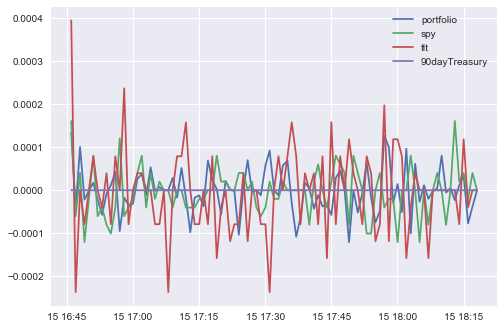

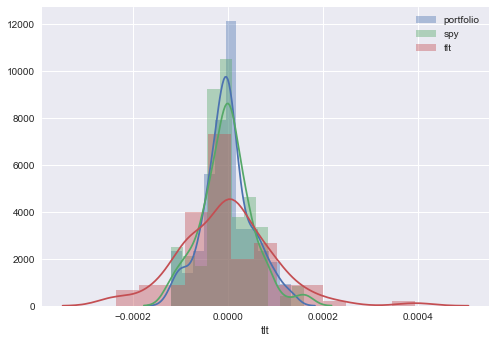

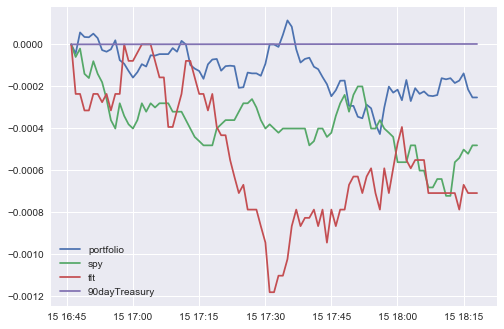

In [183]:
if success:
    plt.figure()
    plt.plot(df['portfolio'])
    plt.plot(df['spy'])
    plt.plot(df['tlt'])
    plt.plot(df['90dayTreasury'])
    plt.legend()
    plt.figure()
    sns.distplot(df['portfolio'],label="portfolio")
    sns.distplot(df['spy'],label="spy")
    sns.distplot(df['tlt'],label="tlt")
    plt.legend()
    
    plt.figure()
    plt.plot(cumulative['portfolio'])
    plt.plot(cumulative['spy'])
    plt.plot(cumulative['tlt'])
    plt.plot(cumulative['90dayTreasury'])
    plt.legend()

In [184]:
if success:
    df['elapsed'] = df.index-df.index[0]
    year = datetime.timedelta(days=365)
    percentageOfYear = divtd((df['elapsed'])[-1], year)
    
    df['spyExcess'] = df['spy']-df['90dayTreasury']
    df['tltExcess'] = df['tlt']-df['90dayTreasury']
    df['portfolioExcess'] = df['portfolio']-df['90dayTreasury']
    df['spyInfoExcess'] = df['portfolio']-df['spy']
    df['tltInfoExcess'] = df['portfolio']-df['tlt']
    
    
    meanSpyExcess = df['spyExcess'].mean()
    meanTltExcess = df['tltExcess'].mean()
    meanPortfolioExcess = df['portfolioExcess'].mean()
    meanSpyInfoExcess = df['spyInfoExcess'].mean()
    meanTltInfoExcess = df['tltInfoExcess'].mean()
    
    stdSpyExcess = df['spyExcess'].std()
    stdTltExcess = df['tltExcess'].std()
    stdPortfolioExcess = df['portfolioExcess'].std()
    stdSpyInfoExcess = df['spyInfoExcess'].std()
    stdTltInfoExcess = df['tltInfoExcess'].std()
    
    rawSpySharpe = meanSpyExcess/stdSpyExcess
    spySharpe = math.sqrt(len(df.index)/percentageOfYear)*rawSpySharpe
    print('rawSpySharpe = ',rawSpySharpe)
    print('spySharpe = ',spySharpe)
    
    rawTltSharpe = meanTltExcess/stdTltExcess
    tltSharpe = math.sqrt(len(df.index)/percentageOfYear)*rawTltSharpe
    print('\nrawTltSharpe = ',rawTltSharpe)
    print('tltSharpe = ',tltSharpe)
    
    rawPortfolioSharpe = meanPortfolioExcess/stdPortfolioExcess
    portfolioSharpe = math.sqrt(len(df.index)/percentageOfYear)*rawPortfolioSharpe
    print('\nrawPortfolioSharpe = ',rawPortfolioSharpe)
    print('portfolioSharpe = ',portfolioSharpe)
    
    rawSpyInfo = meanSpyInfoExcess/stdSpyInfoExcess
    spyInfo = math.sqrt(len(df.index)/percentageOfYear)*rawSpyInfo
    print('\nrawSpyInfo = ',rawSpyInfo)
    print('spyInfo = ',spyInfo)
    
    rawTltInfo = meanTltInfoExcess/stdTltInfoExcess
    tltInfo = math.sqrt(len(df.index)/percentageOfYear)*rawTltInfo
    print('\nrawTltInfo = ',rawTltInfo)
    print('tltInfo = ',tltInfo)

rawSpySharpe =  -0.06338932227749884
spySharpe =  -46.195399321460634

rawTltSharpe =  -0.034265749538257756
tltSharpe =  -24.971397801658746

rawPortfolioSharpe =  -0.025788486460003014
portfolioSharpe =  -18.793534732880342

rawSpyInfo =  0.03030366750322494
spyInfo =  22.0840035974507

rawTltInfo =  0.01953283573050484
tltInfo =  14.234686758458407
